In [137]:
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Загрузка данных

Ссылка для скачивания датасета: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [59]:
data = pd.read_csv('spam.csv',  encoding = "cp1252")
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


# Первичный анализ данных

In [60]:
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [62]:
data.v1.value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

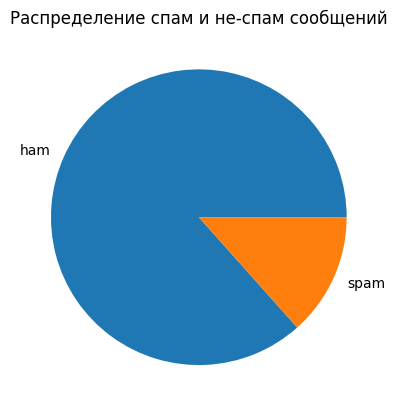

In [63]:
plt.pie(data.v1.value_counts(), labels = data.v1.value_counts().index)
plt.title("Распределение спам и не-спам сообщений")
plt.show()

In [64]:
#Выведем примеры спама и нормальных сообщений
data[data['v1'] == 'spam']['v2'].head(5)

2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: v2, dtype: object

In [65]:
data[data['v1'] == 'ham']['v2'].head(5)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: v2, dtype: object

In [124]:
X = data['v2']
y = data['v1']
y = np.array([1 if el == 'spam' else 0 for el in y])
y

array([0, 0, 1, ..., 0, 0, 0])

In [125]:
y.shape

(5572,)

# Bad of Words(Tfidf) подход

In [126]:
max_words = 20000
tok = TfidfVectorizer()
tok.fit(X)

TfidfVectorizer()

In [127]:
X = tok.transform(X)
X.shape

(5572, 8673)

In [128]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# Протестируем разные модели

In [71]:
def train_test_model(model, x_train, y_train, x_test, y_test, params_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=params_grid, cv=5, n_jobs=10)
    grid_search.fit(x_train, y_train)
    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучшая точность:", grid_search.best_score_)
    return grid_search.best_params_

### Логистическая регрессия

In [72]:
log_reg = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
train_test_model(log_reg, x_train, y_train, x_test, y_test, param_grid)

Лучшие параметры: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
Лучшая точность: 0.9811533370576718


C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 100, 'penalty': 'l1', 'solver': 'saga'}

In [73]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
print("ROC_AUC =", roc_auc_score(log_reg.predict(x_test), y_test))# точность уже очень хорошая
print("ACCURACY_SCORE =",accuracy_score(log_reg.predict(x_test), y_test))

ROC_AUC = 0.9772857658012063
ACCURACY_SCORE = 0.9659192825112107


### Дерево решений

In [74]:
tree = DecisionTreeClassifier()
param_grid = {
    'max_depth': [ 1,3, 5, 10, 30],
    'min_samples_leaf': [1, 2,3,5,10],
}
train_test_model(tree, x_train, y_train, x_test, y_test, param_grid)

Лучшие параметры: {'max_depth': 30, 'min_samples_leaf': 1}
Лучшая точность: 0.9665697835354038


{'max_depth': 30, 'min_samples_leaf': 1}

In [75]:
tree = DecisionTreeClassifier(max_depth = 30, min_samples_leaf = 1)
tree.fit(x_train, y_train)
print("ROC_AUC =", roc_auc_score(tree.predict(x_test), y_test))
print("ACCURACY_SCORE =",accuracy_score(tree.predict(x_test), y_test))


ROC_AUC = 0.9559610524751004
ACCURACY_SCORE = 0.9757847533632287


### Случайный лес

In [76]:
%%time
forest = RandomForestClassifier()
param_grid = {
    'max_depth': [ 1,3, 5, 10],
    'min_samples_leaf': [1, 2,3,5,10],
    'n_estimators':[10, 50, 100, 300]
}
train_test_model(forest, x_train, y_train, x_test, y_test, param_grid)

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 10}
Лучшая точность: 0.9098085991957442
CPU times: total: 1.41 s
Wall time: 37.9 s


{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 10}

In [77]:
forest = RandomForestClassifier(max_depth = 10, min_samples_leaf = 5, n_estimators = 10)
forest.fit(x_train, y_train)
print("ROC_AUC =", roc_auc_score(forest.predict(x_test), y_test))
print("ACCURACY_SCORE =",accuracy_score(forest.predict(x_test), y_test))

ROC_AUC = 0.9421831637372803
ACCURACY_SCORE = 0.8878923766816144


### Бустинг

In [78]:
%%time
catboost = CatBoostClassifier()
params0_grid = { 'iterations' : [100, 500, 1000],
               'learning_rate' : [0.5, 0.1, 0.01],
                'verbose':[0],
                
                'min_data_in_leaf':[1,2,5, 10],
                'depth' : [1,3,5]
            }
train_test_model(catboost, x_train, y_train, x_test, y_test, params0_grid)


Лучшие параметры: {'depth': 5, 'iterations': 500, 'learning_rate': 0.1, 'min_data_in_leaf': 1, 'verbose': 0}
Лучшая точность: 0.9773406712868595
CPU times: total: 57.7 s
Wall time: 20min 46s


{'depth': 5,
 'iterations': 500,
 'learning_rate': 0.1,
 'min_data_in_leaf': 1,
 'verbose': 0}

In [120]:
catboost = CatBoostClassifier(iterations=500, depth=5, learning_rate = 0.1, min_data_in_leaf=1, verbose=0)
catboost.fit(x_train, y_train)


In [121]:
print("ROC_AUC =", roc_auc_score(catboost.predict(x_test), y_test))#бустинг показывает очень хороший результат
print("ACCURACY_SCORE =",accuracy_score(catboost.predict(x_test), y_test))

ROC_AUC = 0.9824520573450009
ACCURACY_SCORE = 0.9865470852017937


# Нейросети

In [116]:
dataset = TensorDataset(torch.from_numpy(x_train.toarray()), torch.from_numpy(y_train).view(4457,1))
# Создание загрузчика данных
dataloader = DataLoader(dataset, batch_size=16)

In [117]:
# Создание модели
model_nn = nn.Sequential(nn.Linear(8673, 1000), nn.ReLU(), nn.Linear(1000, 100), nn.ReLU(), nn.Linear(100, 1), nn.Sigmoid())
model_nn

Sequential(
  (0): Linear(in_features=8673, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): Sigmoid()
)

### Обучение

In [118]:
loss_func = nn.BCELoss()
optim = torch.optim.Adam(model_nn.parameters(), lr=0.001)

In [119]:
%%time
acc= []
roc = []
for epoch in range(3):
    for x_tr, y_tr in tqdm(dataloader):
        y_pred = model_nn(x_tr.float())
        loss = loss_func(y_pred, y_tr.float())
        loss.backward()
        optim.step()
        optim.zero_grad()
    y_pred_t = model_nn(torch.from_numpy(x_test.toarray()).float())
    y_pred_i= (y_pred_t >= 0.5).int()
    acc.append(accuracy_score(y_test, y_pred_i))
    roc.append(roc_auc_score(y_test, y_pred_i))
    print(epoch, "epoch finished, roc auc on test =", roc_auc_score(y_test, y_pred_i), "accuracy on test =", accuracy_score(y_test, y_pred_i))
    



  0%|          | 0/279 [00:00<?, ?it/s]

0 epoch finished, roc auc on test = 0.9775091575091576 accuracy on test = 0.9820627802690582


  0%|          | 0/279 [00:00<?, ?it/s]

1 epoch finished, roc auc on test = 0.956117216117216 accuracy on test = 0.9874439461883409


  0%|          | 0/279 [00:00<?, ?it/s]

2 epoch finished, roc auc on test = 0.953058608058608 accuracy on test = 0.9874439461883409
CPU times: total: 4min 46s
Wall time: 48.8 s


# Word2Vec подход(embedding) + рекурентные сети


In [91]:
# токенизация
tok = Tokenizer(7000)
tok.fit_on_texts(data['v2'])
X_tok = tok.texts_to_sequences(data['v2'])


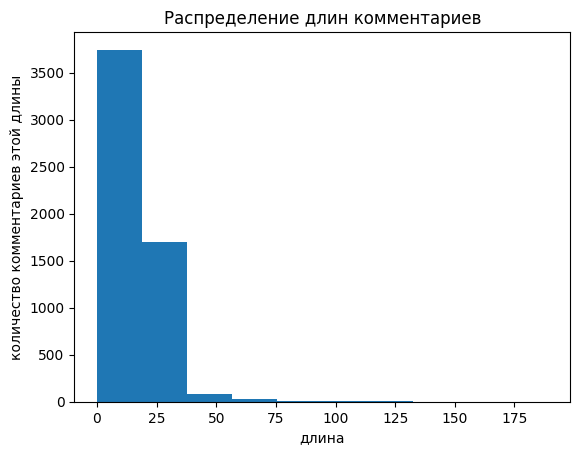

In [168]:
xlen = [len(el) for el in X_tok]
plt.hist(xlen)
plt.xlabel('длина')
plt.ylabel('количество сообщений этой длины')
plt.title("Распределение длин сообщений")
plt.show()

In [93]:
#приводим все комментарии к длине 50
X_seq = torch.tensor(pad_sequences(X_tok, 50))
X_seq.size()

torch.Size([5572, 50])

In [94]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_seq,y, test_size=0.2)

In [95]:
# класс модели
class SpamClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(SpamClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding(x)
    x, _ = self.lstm(x)
    x = x[:, -1, :] # Берем последнее скрытое состояние
    x = self.fc(x)
    x = self.sigmoid(x)
    return x

In [96]:
model = SpamClassifier(7000, 100, 500, 1)

### Обучение

In [97]:
loss_func = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [98]:
%%time
acc= []
roc = []
for epoch in range(3):
    for x_tr, y_tr in tqdm(dataloader):
        y_pred = model(x_tr.int())
        loss = loss_func(y_pred, y_tr.float())
        loss.backward()
        optim.step()
        optim.zero_grad()
    y_pred_t = model(x_test1.int())
    y_pred_i= (y_pred_t >= 0.5).int()
    acc.append(accuracy_score(y_test1, y_pred_i))
    roc.append(roc_auc_score(y_test1, y_pred_i))
    print(epoch, "epoch finished, roc auc on test =", roc_auc_score(y_test1, y_pred_i), "accuracy on test =", accuracy_score(y_test1, y_pred_i))



  0%|          | 0/279 [00:00<?, ?it/s]

0 epoch finished, roc auc on test = 0.5714719974523399 accuracy on test = 0.7874439461883408


  0%|          | 0/279 [00:00<?, ?it/s]

1 epoch finished, roc auc on test = 0.5787422375982515 accuracy on test = 0.8053811659192825


  0%|          | 0/279 [00:00<?, ?it/s]

2 epoch finished, roc auc on test = 0.5828532345150037 accuracy on test = 0.8125560538116592
CPU times: total: 5h 53min 19s
Wall time: 59min 56s


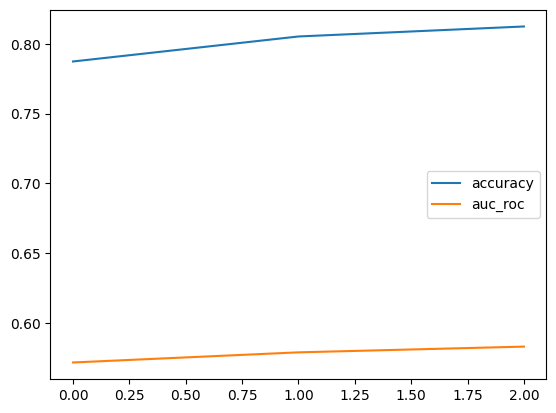

In [101]:
plt.plot(acc, label = 'accuracy')
plt.plot(roc, label = 'auc_roc')
plt.lab
plt.legend()

# Выбор лучшей модели и максимизация метрик

Лучшей моделью и по accuracy, и по roc_auc метрике оказался градиентный бустинг!

### Строительство recision-recall кривой

In [129]:
catboost = CatBoostClassifier(iterations=500, depth=5, learning_rate = 0.1, min_data_in_leaf=1, verbose=0)
catboost.fit(x_train, y_train)


In [130]:
print("ROC_AUC =", roc_auc_score(catboost.predict(x_test), y_test))#бустинг показывает очень хороший результат
print("ACCURACY_SCORE =",accuracy_score(catboost.predict(x_test), y_test))

ROC_AUC = 0.9722965894540798
ACCURACY_SCORE = 0.9829596412556054


In [136]:
y_pred_b = catboost.predict_proba(x_test)[:,1]
y_pred_b

array([0.00450032, 0.00419862, 0.00584278, ..., 0.990426  , 0.00491322,
       0.00118552])

In [135]:
y_test

array([0, 0, 0, ..., 1, 0, 0])

In [139]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_b)

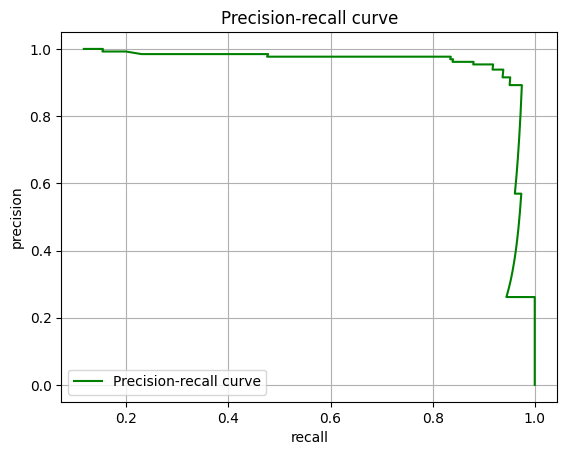

In [161]:
plt.plot(precision, recall, label = 'Precision-recall curve', color='g')
plt.title("Precision-recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend()
plt.grid()
plt.show()

### Подбор порогов

В разных задачах требуется максимизация разных метрик, ниже приведенены функции максимизации одной из метрик, 
при условии удержания второй не ниже определенного значения

In [164]:
# precision не ниже pr
def predict_pr(x_test, pr):
    id = np.searchsorted(sorted(precision), pr)
    y_pred = catboost.predict_proba(x_test)[:,1]
    y_pred_i = (y_pred >= thresholds[id]).astype(int)
    print("Precision=",precision_score(y_test, y_pred_i), '\n', "Recall=", recall_score(y_test, y_pred_i))
    return(y_pred_i)
    

In [165]:
# recall не ниже rec
def predict_rec(x_test, rec):
    id = len(recall)-np.searchsorted(sorted(recall), rec, side='left')-1
    y_pred = catboost.predict_proba(x_test)[:,1]
    y_pred_i = (y_pred >= thresholds[id]).astype(int)
    print("Precision=",precision_score(y_test, y_pred_i), '\n', "Recall=", recall_score(y_test, y_pred_i))
    return(y_pred_i)

In [166]:
pred_rec = predict_rec(x_test, 0.95)

Precision= 0.9185185185185185 
 Recall= 0.9538461538461539


In [167]:
pred_prec = predict_pr(x_test, 0.9)

Precision= 0.9117647058823529 
 Recall= 0.9538461538461539
